In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two CSV files
# df1 = pd.read_csv('./Data/Prof_Office_Data/office_group_records_07_02.csv')

df1 = pd.read_csv('./Data/Prof_Office_Data/office_group_records_all.csv')
# df2 = pd.read_csv('./Data/Prof_Office_Data/office_actuator_records.csv')

#original_df = df1.copy() #Keep a copy to compare
## Toggle the values of Light Sensor.
df1.loc[df1['sensor_name'] == 'Light Sensor', 'state'] = 1 - df1['state']

# # Find rows where 'state' has changed
# changed_rows = df1[df1['state'] != original_df['state']]

# # Display only the changed rows
# print(changed_rows)

#remove the motion sensor data
# filtered_df1 = df1[df1['sensor_name'] != 'Motion Sensor']
# print(filtered_df1)


# Combine the two DataFrames (concatenating rows)
# combined_office_data = pd.concat([df1, df2], ignore_index=True)
combined_office_data = df1

# Convert the 'datetime' column to a datetime data type if necessary
combined_office_data['datetime'] = pd.to_datetime(combined_office_data['seconds'], unit='s')
# combined_office_data['datetime'] = pd.to_datetime(combined_office_data['date'] + ' ' + combined_office_data['time'], format='%d/%m/%y %H:%M')

# Sort by the 'datetime' column
combined_office_data = combined_office_data.sort_values(by='datetime')

# Display the sorted, combined DataFrame
# print(combined_office_data.head)
unique_items = combined_office_data['sensor_name'].unique()
print(unique_items)


['Office Door Sensor' 'Office Door Motion Sensor' 'Desk Motion Sensor'
 'Office Light Sensor']


In [25]:
## total active sensors and actuators for a time window

#Only consider the data from august 12 to october 10
start_date = pd.to_datetime('2024-08-12')
end_date = pd.to_datetime('2024-10-10')
filtered_office_data = combined_office_data[(combined_office_data['datetime'] >= start_date) & (combined_office_data['datetime'] <= end_date)]
print(filtered_office_data.shape)

filtered_office_data = filtered_office_data.set_index('datetime') #make the date column as index


## Data from july 02

combined_office_data = combined_office_data.set_index('datetime') #make the date column as index

# combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
# print(combined_office_data.size, combined_office_data_filtered.size)
office_hourly = combined_office_data.state.resample('4h').sum() #resample on hourly basis and get summary of sensor values on that hour.
# print(office_hourly.head(10))

filtered_August_office_hourly = filtered_office_data.state.resample('4h').sum()

#only take the resampled data from 7am to 7pm
office_hourly = office_hourly.between_time('08:00', '18:00')
office_hourly = office_hourly.reset_index()

filtered_August_office_hourly = filtered_August_office_hourly.between_time('09:00', '18:00')
filtered_August_office_hourly = filtered_August_office_hourly.reset_index()

combined_office_data = combined_office_data.reset_index()
filtered_office_data = filtered_office_data.reset_index()
print(office_hourly.shape)
# office_hourly.to_csv('test.csv', index=False)

(14414, 8)
(1370, 2)


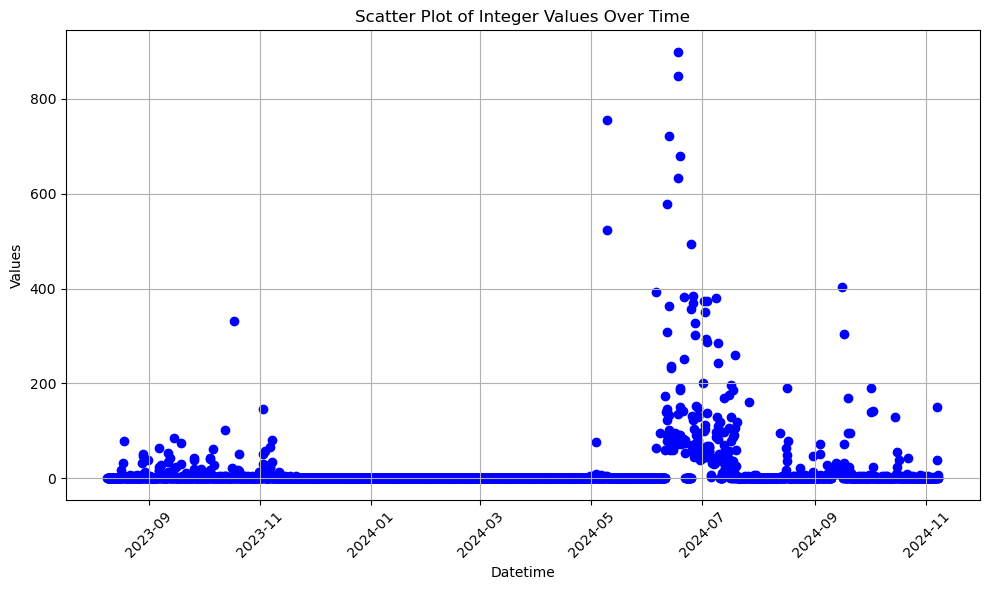

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(office_hourly['datetime'], office_hourly['state'], color='blue', marker='o')

# Formatting the plot
plt.title('Scatter Plot of Integer Values Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.grid(True)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

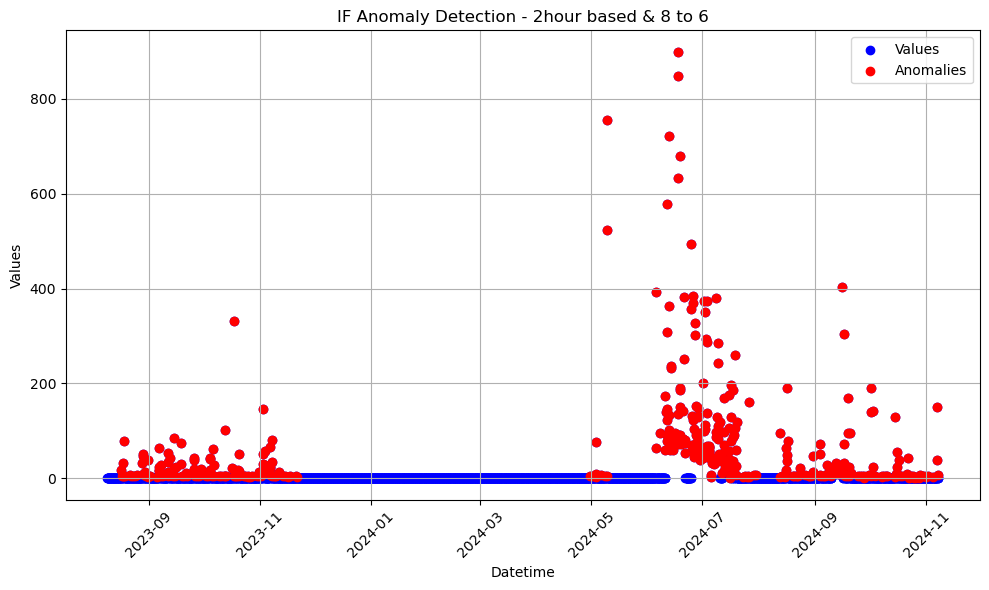

Total anomalies: 479, Percentage of anomalous values: 17.48175182481752%
Empty DataFrame
Columns: [datetime, state, anomaly]
Index: []
                datetime  state  anomaly
0    2023-08-09 08:00:00    0.0        1
1    2023-08-09 10:00:00    0.0        1
2    2023-08-09 12:00:00    0.0        1
3    2023-08-09 14:00:00    0.0        1
4    2023-08-09 16:00:00    0.0        1
...                  ...    ...      ...
2732 2024-11-06 12:00:00    0.0        1
2735 2024-11-06 18:00:00    0.0        1
2736 2024-11-07 08:00:00    0.0        1
2737 2024-11-07 10:00:00    0.0        1
2738 2024-11-07 12:00:00    0.0        1

[2261 rows x 3 columns]


In [22]:
from sklearn.ensemble import IsolationForest

# office_hourly['datetime'] = pd.to_datetime(office_hourly['datetime'])

# Prepare data for IsolationForest
values = office_hourly[['state']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest(contamination='auto', random_state=42)
office_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = office_hourly[office_hourly['anomaly'] == -1]
non_anomalies = office_hourly[office_hourly['anomaly'] == 1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(office_hourly['datetime'], office_hourly['state'], label='Values', color='blue', marker='o')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.title('IF Anomaly Detection - 2hour based & 8 to 6')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('./Plots/Office_plots/IF_6H_9-6.png')
plt.show()


count_anomaly_h = (office_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(office_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( non_anomalies)

# non_anomalies.to_csv('./Output_CSV/regular_office.csv', index=False)
# anomalies.to_csv('./Output_CSV/anomaly_office.csv', index=False)
# office_hourly.to_csv('./Output_CSV/office_data/IF_anomaly_2h.csv', index=False)

In [119]:
# # using ocsvm
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import OneClassSVM

# scaler = StandardScaler()  # OC-SVM benefits from scaling the data
# office_hourly['scaled_states'] = scaler.fit_transform(office_hourly[['state']])

# # Train OC-SVM
# ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)  # nu=0.05 means 5% anomalies expected
# office_hourly['anomaly'] = ocsvm.fit_predict(office_hourly[['scaled_states']])

# # In OC-SVM, -1 indicates an anomaly, and 1 indicates normal data
# anomalies = office_hourly[office_hourly['anomaly'] == -1]
# non_anomalies = office_hourly[office_hourly['anomaly'] == 1]

# plt.figure(figsize=(10, 6))
# plt.scatter(office_hourly['datetime'], office_hourly['state'], label='Values', color='blue')
# plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
# plt.xlabel('Datetime')
# plt.ylabel('Values')
# plt.title('OC-SVM Anomaly Detection - 6H based, Total 24H, Nu=0.1')
# plt.legend()
# # plt.savefig('./Plots/Office_plots/SVM_6H_1.png')
# plt.show()

# count_anomaly_h = (office_hourly['anomaly'] == -1).sum()

# # Calculate the percentage of values equal to -1
# percentage_h = (count_anomaly_h / len(office_hourly)) * 100
# print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

# #only print the non anomalous values which are not zero
# df_filtered = non_anomalies[non_anomalies['state'] != 0]
# print(df_filtered)

# print( non_anomalies)

# non_anomalies.to_csv('./Output_CSV/regular_office_svm.csv', index=False)
# anomalies.to_csv('./Output_CSV/anomaly_office_svm.csv', index=False)

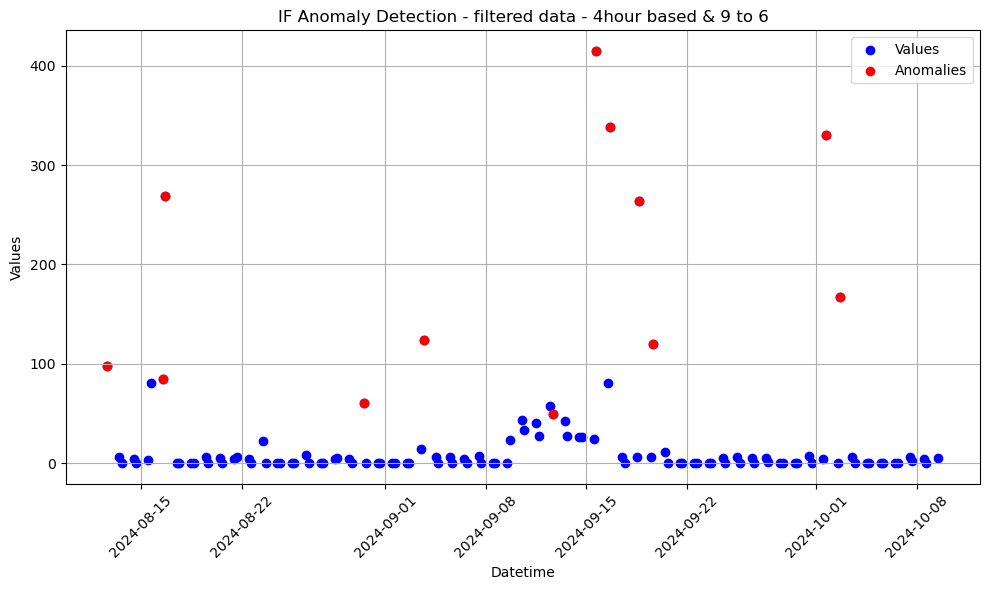

Total anomalies: 12, Percentage of anomalous values: 10.344827586206897%
               datetime  state  anomaly
1   2024-08-13 12:00:00    6.0        1
3   2024-08-14 12:00:00    4.0        1
5   2024-08-15 12:00:00    3.0        1
6   2024-08-15 16:00:00   81.0        1
13  2024-08-19 12:00:00    6.0        1
15  2024-08-20 12:00:00    5.0        1
17  2024-08-21 12:00:00    4.0        1
18  2024-08-21 16:00:00    6.0        1
19  2024-08-22 12:00:00    4.0        1
21  2024-08-23 12:00:00   22.0        1
27  2024-08-26 12:00:00    8.0        1
31  2024-08-28 12:00:00    4.0        1
32  2024-08-28 16:00:00    5.0        1
33  2024-08-29 12:00:00    4.0        1
43  2024-09-03 12:00:00   14.0        1
45  2024-09-04 12:00:00    6.0        1
47  2024-09-05 12:00:00    6.0        1
49  2024-09-06 12:00:00    4.0        1
51  2024-09-07 12:00:00    7.0        1
56  2024-09-09 16:00:00   23.0        1
57  2024-09-10 12:00:00   43.0        1
58  2024-09-10 16:00:00   33.0        1
59  202

In [120]:
# Filtered office data from august to october - Isolation forest

from sklearn.ensemble import IsolationForest

# office_hourly['datetime'] = pd.to_datetime(office_hourly['datetime'])

# Prepare data for IsolationForest
values = filtered_August_office_hourly[['state']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest(contamination=0.1, random_state=42)
filtered_August_office_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = filtered_August_office_hourly[filtered_August_office_hourly['anomaly'] == -1]
non_anomalies_Aug = filtered_August_office_hourly[filtered_August_office_hourly['anomaly'] == 1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(filtered_August_office_hourly['datetime'], filtered_August_office_hourly['state'], label='Values', color='blue', marker='o')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.title('IF Anomaly Detection - filtered data - 4hour based & 9 to 6')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('./Plots/Office_plots/IF_Aug_6H_9-6.png')
plt.show()


count_anomaly_h = (filtered_August_office_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(filtered_August_office_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies_Aug[non_anomalies_Aug['state'] != 0]
print(df_filtered)

print( non_anomalies_Aug)

# non_anomalies_Aug.to_csv('./Output_CSV/regular_office.csv', index=False)
# filtered_August_office_hourly.to_csv('./Output_CSV/office_data/anomaly_office_Aug_2h.csv', index=False)

In [38]:
#FNE and TD implementations
from math import ceil
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from neighbor_group import *
from sklearn.manifold import SpectralEmbedding

def frequent_next_event(df, adjacency_matrix):
    prev_row = df.iloc[0]
    for _,cur_row in df.iterrows():
        if (cur_row.sensor_name != prev_row.sensor_name):
            t = max(ceil(cur_row.seconds - prev_row.seconds), 1.0)
            # t = max(ceil((cur_row.DateTime - prev_row.DateTime).total_seconds()),1.0)
            adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
        prev_row = cur_row
    
    return adjacency_matrix

def time_delta(df, adjacency_matrix, th=2):
    cur_group = []
    prev_row = df.iloc[0]
    for _, cur_row in df.iterrows():
        if ((cur_row.seconds - prev_row.seconds) >= th):
            cur_group = []
        if not(cur_row.sensor_name in cur_group):
            cur_group.append(cur_row.sensor_name)
        for item in cur_group:
            adjacency_matrix[item][cur_row.sensor_name] += 1
        prev_row = cur_row
    
    return adjacency_matrix


def get_sensor_groups(adjacency_matrix):
    # Fixed cluster number
    n = 2
    max_ch = 0
    stop_iter = 10
    cluster_score_dict = {}
    patience = 0

    spectral_clustering = SpectralClustering(2, affinity="precomputed")
    cluster = spectral_clustering.fit_predict(adjacency_matrix)
    embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
        
    features = embedding.fit_transform(adjacency_matrix)

    ch_score = calinski_harabasz_score(features, cluster)
    silhouette_avg = silhouette_score(features, cluster)
    db_score = davies_bouldin_score(features, cluster)

    cluster_score_dict['cluster_number'] = 2
    cluster_score_dict['ch-score'] = ch_score
    cluster_score_dict['silhoutte-score'] = silhouette_avg
    cluster_score_dict['db-score'] = db_score
    cluster_score_dict['cluster'] = cluster
    print(cluster_score_dict)

    cluster_dict = get_cluster_sensor_list(cluster_score_dict['cluster'], adjacency_matrix)
    adjacency_matrix_list, unique_sensors = get_adjacency_matrix_list(cluster_dict, adjacency_matrix)

    # Get groups based on fixed nearest nodes
    sensor_group = {}
    sensor_number_each_group = 3  # Select the sensor numbers that will used to pick top nearest nodes
    i = 1 
    for index, matrix in enumerate(adjacency_matrix_list):
        groups = get_groups(matrix, sensor_number_each_group, unique_sensors[index])
        for group in groups:
            item_list = []
            for item in group:
                item_list.append(item)
            sensor_group['G'+ str(i)] = item_list
            i += 1

    # sensor_group_df = pd.DataFrame(sensor_group)
    # print(sensor_group)
    return cluster_score_dict

In [13]:
unique_sensor = combined_office_data.sensor_name.unique()

fnq_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)

print('Frequent next event starts')
print('---------------------------')
fnq_adjacency_matrix = frequent_next_event(combined_office_data, fnq_adjacency_matrix)
print('---------------------------')
print('Frequent next event ends')

print('Time Delta starts')
print('---------------------------')
td_adjacency_matrix = time_delta(combined_office_data, td_adjacency_matrix)
print('---------------------------')
print('Time Delta ends')

Frequent next event starts
---------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\1229693141.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t


---------------------------
Frequent next event ends
Time Delta starts
---------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\1229693141.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[item][cur_row.sensor_name] += 1


---------------------------
Time Delta ends


In [14]:
fne_scores = get_sensor_groups(adjacency_matrix=fnq_adjacency_matrix)

print("~~~ Time Delta results ~~~")

td_scores = get_sensor_groups(td_adjacency_matrix)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anacon

{'cluster_number': 2, 'ch-score': 15.661592244868565, 'silhoutte-score': 0.5374713437612322, 'db-score': 0.15970219054637605, 'cluster': array([1, 1, 1, 0])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Desk Motion Sensor']
['Office Light Sensor']
number of unique group  1
('Desk Motion Sensor', 'Office Door Motion Sensor', 'Office Door Sensor')
number of unique group  1
('Office Light Sensor',)
{'G1': ['Desk Motion Sensor', 'Office Door Motion Sensor', 'Office Door Sensor'], 'G2': ['Office Light Sensor']}
~~~ Time Delta results ~~~
{'cluster_number': 2, 'ch-score': 17.225783752647757, 'silhoutte-score': 0.5463468009011352, 'db-score': 0.15005393997206806, 'cluster': array([0, 0, 0, 1])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Desk Motion Sensor']
['Office Light Sensor']
number of unique group  1
('Desk Motion Sensor', 'Office Door Motion Sensor', 'Office Door Sensor')
number of unique group  1
('Office Light Sensor',)
{'G1': ['Desk Motion Sensor', 'Office Door Mot

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [34]:
def anomaly_detection_and_removal(df, timeWindow = 'h'):
    df = df.set_index('datetime') #make the date column as index

    # combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
    # print(combined_office_data.size, combined_office_data_filtered.size)
    df_hourly = df.state.resample(timeWindow).sum() #resample on hourly basis and get summary of sensor values on 2 hours.

    df_hourly = df_hourly.between_time('08:00', '18:00')
    df_hourly = df_hourly.reset_index()
    
    values = df_hourly[['state']]  # Selecting the 'values' column as input for the model

    # Initialize and fit the IsolationForest model
    model = IsolationForest(contamination='auto', random_state=42)
    df_hourly['anomaly'] = model.fit_predict(values)

    # Isolation Forest outputs:
    # -1 for anomalies
    #  1 for normal data points

    # Filter the anomalies
    # anomalies = lab_hourly[lab_hourly['anomaly'] == -1]
    regular = df_hourly[df_hourly['anomaly'] == 1]
    

    regular_date = regular.set_index('datetime')
    regular_idx = regular_date.index
    # print(regular_idx)

    # Filtering out the hourly anomalous data from the original data
    filtered_df = df[df.index.floor(timeWindow).isin(regular_idx)].reset_index()
    return filtered_df

In [ ]:
## Get dynamic window

def get_time_window(original_data, min_window = 1, max_window = 6):
    unique_sensor = original_data.sensor_name.unique()
    fnq_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
    
    best_window = None
    highest_score = float('-inf')  # Start with the lowest possible value
    for window in range(min_window, max_window+1):
        fd = anomaly_detection_and_removal(original_data, f'{window}h')
        print(fd.shape)
        if fd.empty: continue
        fnq_adjacency_matrix_filtered = frequent_next_event(fd, fnq_adjacency_matrix_filtered)
        clustering_scores = get_sensor_groups(adjacency_matrix=fnq_adjacency_matrix_filtered)
        current_score = clustering_scores['ch-score']
        print(f"current window: {window}, current ch score: {current_score}")
        if current_score > highest_score:
            highest_score = current_score
            best_window = window
    return best_window, highest_score

bw, hs = get_time_window(combined_office_data, 1, 12)
print(f"best window: {bw}, highest ch score: {hs}")


(1, 8)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


{'cluster_number': 2, 'ch-score': 0.9778346083163985, 'silhoutte-score': -0.01931555896114799, 'db-score': 1.3896583200980186, 'cluster': array([1, 0, 0, 1])}
['Office Door Sensor', 'Office Light Sensor']
['Office Door Motion Sensor', 'Desk Motion Sensor']
number of unique group  1
('Office Door Sensor', 'Office Light Sensor')
number of unique group  1
('Desk Motion Sensor', 'Office Door Motion Sensor')
current window: 1, current ch score: -0.01931555896114799
(1, 8)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


{'cluster_number': 2, 'ch-score': 1.4773885165430036, 'silhoutte-score': 0.07600141044510264, 'db-score': 1.119143672856115, 'cluster': array([1, 1, 0, 0])}
['Office Door Sensor', 'Office Door Motion Sensor']
['Desk Motion Sensor', 'Office Light Sensor']
number of unique group  1
('Office Door Motion Sensor', 'Office Door Sensor')
number of unique group  1
('Desk Motion Sensor', 'Office Light Sensor')
current window: 2, current ch score: 0.07600141044510264
(896, 8)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\855446919.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_sp

{'cluster_number': 2, 'ch-score': 45.09354217253431, 'silhoutte-score': 0.6280869601576035, 'db-score': 0.09702502422459312, 'cluster': array([0, 0, 1, 0])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Office Light Sensor']
['Desk Motion Sensor']
number of unique group  1
('Office Door Motion Sensor', 'Office Door Sensor', 'Office Light Sensor')
number of unique group  1
('Desk Motion Sensor',)
current window: 3, current ch score: 0.6280869601576035
(919, 8)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\855446919.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_sp

{'cluster_number': 2, 'ch-score': 90.66432515720611, 'silhoutte-score': 0.6640042273640429, 'db-score': 0.06857740357658584, 'cluster': array([0, 0, 1, 0])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Office Light Sensor']
['Desk Motion Sensor']
number of unique group  1
('Office Door Motion Sensor', 'Office Door Sensor', 'Office Light Sensor')
number of unique group  1
('Desk Motion Sensor',)
current window: 4, current ch score: 0.6640042273640429
(0, 8)
(1031, 8)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\855446919.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_sp

{'cluster_number': 2, 'ch-score': 144.81582327730345, 'silhoutte-score': 0.6817346991929125, 'db-score': 0.05419766513334916, 'cluster': array([0, 0, 1, 0])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Office Light Sensor']
['Desk Motion Sensor']
number of unique group  1
('Office Door Motion Sensor', 'Office Door Sensor', 'Office Light Sensor')
number of unique group  1
('Desk Motion Sensor',)
current window: 6, current ch score: 0.6817346991929125
(0, 8)
(1102, 8)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\855446919.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_sp

{'cluster_number': 2, 'ch-score': 205.3351599643055, 'silhoutte-score': 0.6925542173664255, 'db-score': 0.04547497787123218, 'cluster': array([1, 1, 0, 1])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Office Light Sensor']
['Desk Motion Sensor']
number of unique group  1
('Office Door Motion Sensor', 'Office Door Sensor', 'Office Light Sensor')
number of unique group  1
('Desk Motion Sensor',)
current window: 8, current ch score: 0.6925542173664255
(0, 8)
(0, 8)
(0, 8)
(3707, 8)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\855446919.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_sp

{'cluster_number': 2, 'ch-score': 15.064730449714096, 'silhoutte-score': 0.5412629203505643, 'db-score': 0.16842657865625976, 'cluster': array([0, 0, 1, 0])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Office Light Sensor']
['Desk Motion Sensor']
number of unique group  1
('Office Door Motion Sensor', 'Office Door Sensor', 'Office Light Sensor')
number of unique group  1
('Desk Motion Sensor',)
current window: 12, current ch score: 0.5412629203505643
best window: 8, highest ch score: 0.6925542173664255


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [27]:
unique_sensor = combined_office_data.sensor_name.unique()

fnq_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)

# filtered data after detecting and removing anomaly based on 4 hour data partition
fd = anomaly_detection_and_removal(combined_office_data, '4h')
print('Frequent next event starts')
print('---------------------------')
fnq_adjacency_matrix_filtered = frequent_next_event(fd, fnq_adjacency_matrix_filtered)
print('---------------------------')
print('Frequent next event ends')

print('Time Delta starts')
print('---------------------------')
td_adjacency_matrix_filtered = time_delta(fd, td_adjacency_matrix_filtered)
print('---------------------------')
print('Time Delta ends')

fne_scores_filtered = get_sensor_groups(adjacency_matrix=fnq_adjacency_matrix_filtered)

print("~~~ Time Delta results ~~~")

td_scores_filtered = get_sensor_groups(td_adjacency_matrix_filtered)

Frequent next event starts
---------------------------
---------------------------
Frequent next event ends
Time Delta starts
---------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\1229693141.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
C:\Users\ASUS\AppData\Local\Temp\ipykernel_33288\1229693141.p

---------------------------
Time Delta ends


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\

{'cluster_number': 2, 'ch-score': 45.6299552363857, 'silhoutte-score': 0.6296115636450688, 'db-score': 0.09685041199084973, 'cluster': array([0, 0, 1, 0])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Office Light Sensor']
['Desk Motion Sensor']
number of unique group  1
('Office Door Motion Sensor', 'Office Door Sensor', 'Office Light Sensor')
number of unique group  1
('Desk Motion Sensor',)
{'G1': ['Office Door Motion Sensor', 'Office Door Sensor', 'Office Light Sensor'], 'G2': ['Desk Motion Sensor']}
~~~ Time Delta results ~~~
{'cluster_number': 2, 'ch-score': 95.47622991419387, 'silhoutte-score': 0.670700691119177, 'db-score': 0.06806745716596763, 'cluster': array([0, 0, 1, 0])}
['Office Door Sensor', 'Office Door Motion Sensor', 'Office Light Sensor']
['Desk Motion Sensor']
number of unique group  1
('Office Door Motion Sensor', 'Office Door Sensor', 'Office Light Sensor')
number of unique group  1
('Desk Motion Sensor',)
{'G1': ['Office Door Motion Sensor', 'Office Door 

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [29]:
perc_CH_FNE = (fne_scores_filtered['ch-score'] - fne_scores['ch-score'])/fne_scores['ch-score'] *100
perc_SH_FNE = (fne_scores_filtered['silhoutte-score'] - fne_scores['silhoutte-score'])/fne_scores['silhoutte-score'] *100
perc_DB_FNE = (fne_scores_filtered['db-score'] - fne_scores['db-score'])/fne_scores['db-score'] *100

print(perc_CH_FNE, perc_SH_FNE, perc_DB_FNE)

perc_CH_TD = (td_scores_filtered['ch-score'] - td_scores['ch-score'])/td_scores['ch-score'] *100
perc_SH_TD = (td_scores_filtered['silhoutte-score'] - td_scores['silhoutte-score'])/td_scores['silhoutte-score'] *100
perc_DB_TD = (td_scores_filtered['db-score'] - td_scores['db-score'])/td_scores['db-score'] *100

print(perc_CH_TD, perc_SH_TD, perc_DB_TD)

191.34940128029513 17.143280465715254 -39.35561456013638
454.26348829857056 22.76098075671617 -54.63800738678497


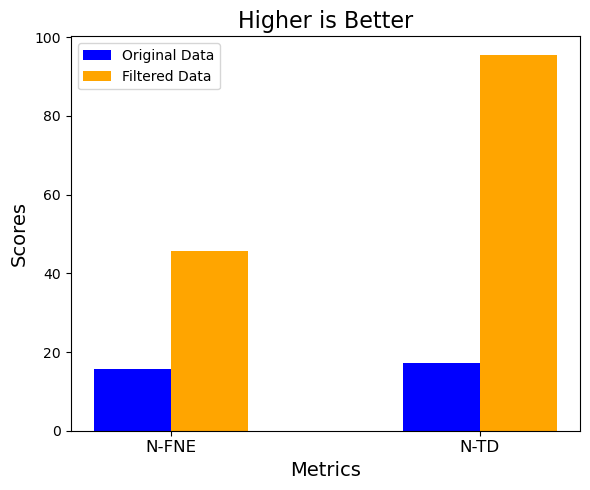

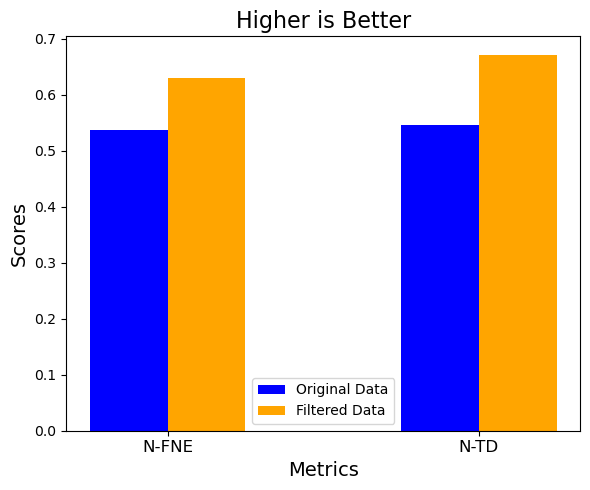

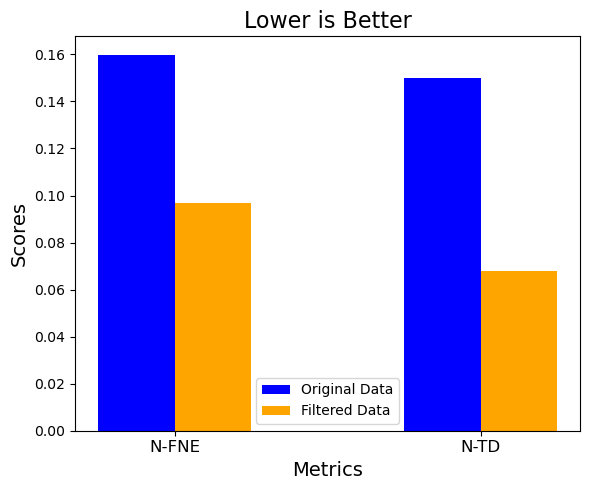

In [30]:
import numpy as np
def get_scores_plots(metrics, originalScores, filteredScores, title = 'Comparison of different Scores of Two Datasets for Two Algorithms'):
    # Set up the bar plot
    x = np.arange(2)  # label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot bars for each dataset
    bars1 = ax.bar(x - width/2, originalScores, width, label='Original Data', color='blue')
    bars2 = ax.bar(x + width/2, filteredScores, width, label='Filtered Data', color='orange')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Metrics', fontsize=14)
    ax.set_ylabel('Scores', fontsize=14)
    ax.set_title(title,  fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(["N-FNE", "N-TD"], fontsize=12)
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.savefig(f"{metrics}.png", dpi=300)
    plt.show()

get_scores_plots(metrics = "./Plots/Office_plots/office_CH", originalScores= [fne_scores['ch-score'], td_scores['ch-score']], filteredScores= [fne_scores_filtered['ch-score'], td_scores_filtered['ch-score']], title= 'Higher is Better')
get_scores_plots(metrics = "./Plots/Office_plots/office_SH", originalScores= [fne_scores['silhoutte-score'], td_scores['silhoutte-score']], filteredScores= [fne_scores_filtered['silhoutte-score'], td_scores_filtered['silhoutte-score']], title= 'Higher is Better')
get_scores_plots(metrics = "./Plots/Office_plots/office_DB", originalScores= [fne_scores['db-score'], td_scores['db-score']], filteredScores= [fne_scores_filtered['db-score'], td_scores_filtered['db-score']], title= 'Lower is Better')


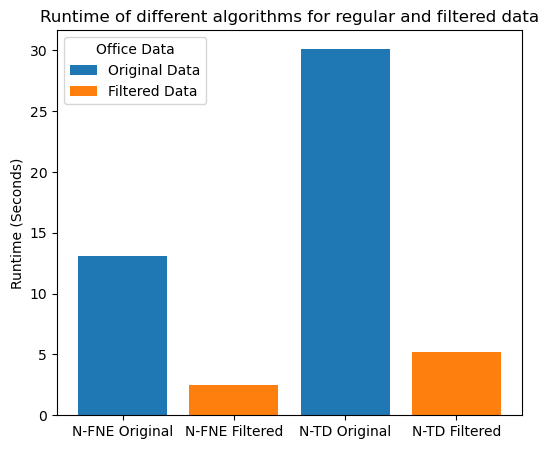

In [ ]:
import time

fnq_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
fnq_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)

runtimes = []
functions = ['N-FNE Original', 'N-FNE Filtered', 'N-TD Original', 'N-TD Filtered']

# # Runtime for FNE original data
# start_time = time.time()
# frequent_next_event(combined_office_data, fnq_adjacency_matrix)
# end_time = time.time()

# runtime1 = end_time - start_time
# runtimes.append(runtime1)

# # Runtime for FNE filtered data
# start_time = time.time()
# fd = anomaly_detection_and_removal(combined_office_data, '4h')
# frequent_next_event(fd, fnq_adjacency_matrix_filtered)
# end_time = time.time()

# runtime2 = end_time - start_time
# runtimes.append(runtime2)

# # Runtime for TD original Data
# start_time = time.time()
# time_delta(combined_office_data, td_adjacency_matrix)
# end_time = time.time()

# runtime3 = end_time - start_time
# runtimes.append(runtime3)

# # Runtime for TD filtered data
# start_time = time.time()
# fd2 = anomaly_detection_and_removal(combined_office_data, '4h')
# time_delta(fd2, td_adjacency_matrix_filtered)
# end_time = time.time()

# runtime4 = end_time - start_time
# runtimes.append(runtime4)

# print(runtimes)

runtimes = [13.089284420013428, 2.487198829650879, 30.147459506988525, 5.232787370681763]

fig, ax = plt.subplots(figsize=(6, 5))
bar_labels = ['Original Data', 'Filtered Data', '_Original Data', '_Filtered Data']
bar_colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']

ax.bar(functions, runtimes, label=bar_labels, color=bar_colors)

ax.set_ylabel('Runtime (Seconds)')
# ax.set_title('Runtime of different algorithms for regular and filtered data')
ax.legend(title='Office Data')

plt.show()